# Imports

In [10]:
from dataclasses import dataclass
from typing import List, Dict, Optional
import pandas as pd
import sqlite3
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.stats as stats
import seaborn as sns

In [14]:
file_location = "../rsds-20241113"

# Analysis prep

define custom data types

In [11]:
@dataclass
class SignalEvent:
    time: int                  # Unix timestamp (ms)
    kind: str                  # Raw Redspot signal kind
    panel: str                 # Panel UUID
    args: dict                 # Parsed JSON args

@dataclass
class ActionEvent:
    time: int
    action_type: str           # edit, execute, output, structure
    cell_id: Optional[str]

Define functions for analysis prep

In [20]:
def load_signals(sqlite_path: str) -> List[SignalEvent]:
    """
    Load all signal records from the Redspot SQLite database.

    Parameters
    ----------
    sqlite_path : str
        Path to the Redspot SQLite database.

    Returns
    -------
    List[SignalEvent]
        Chronologically ordered signal events.
    """
    # connect to the SQLite database
    conn = sqlite3.connect(sqlite_path)
    conn.row_factory = sqlite3.Row
    cursor = conn.cursor()

    cursor.execute("""
        SELECT time, kind, panel, args
        FROM signal
        ORDER BY time ASC
    """)

    events: List[SignalEvent] = []

    # parse each row into a SignalEvent
    for row in cursor.fetchall():
        try:
            args = json.loads(row["args"])
        except json.JSONDecodeError:
            args = {}

        events.append(
            SignalEvent(
                time=int(row["time"]),
                kind=row["kind"],
                panel=row["panel"],
                args=args
            )
        )

    # close the connection
    conn.close()
    return events

def extract_action_events(signals: List[SignalEvent]) -> List[ActionEvent]:
    """
    Convert low-level Redspot signals into higher-level interaction actions.

    The following mappings are applied:
    - ISharedCell.changed:sourceChange -> edit
    - ISharedCell.changed:executionCountChange -> execute
    - ISharedCell.changed:outputsChange -> output
    - INotebookModel.changed:cellsChange -> structure

    Parameters
    ----------
    signals : List[SignalEvent]

    Returns
    -------
    List[ActionEvent]
        Chronologically ordered interaction actions.
    """
    actions: List[ActionEvent] = []

    for s in signals:
        if s.kind == "ISharedCell.changed:sourceChange":
            actions.append(ActionEvent(s.time, "edit", s.args.get("cell")))
        elif s.kind == "ISharedCell.changed:executionCountChange":
            actions.append(ActionEvent(s.time, "execute", s.args.get("cell")))
        elif s.kind == "ISharedCell.changed:outputsChange":
            actions.append(ActionEvent(s.time, "output", s.args.get("cell")))
        elif s.kind == "INotebookModel.changed:cellsChange":
            actions.append(ActionEvent(s.time, "structure", None))
    return actions

def compute_edit_metrics(actions: List[ActionEvent]) -> Dict[str, float]:
    """
    Compute editing-related interaction metrics.

    Metrics:
    - total_edits
    - edits_per_minute
    - mean_edit_burst_length
    - total_edit_bursts

    Parameters
    ----------
    actions : List[ActionEvent]

    Returns
    -------
    Dict[str, float]
    """
    edit_actions = [a for a in actions if a.action_type == "edit"]
    total_edits = len(edit_actions)

    if not actions or total_edits == 0:
        return {
            "total_edits": 0.0,
            "edits_per_minute": 0.0,
            "mean_edit_burst_length": 0.0,
        }

    start_time = actions[0].time
    end_time = actions[-1].time
    duration_minutes = max((end_time - start_time) / 60000.0, 1e-6) # prevent division by zero
    edits_per_minute = total_edits / duration_minutes

    # Edit bursts: consecutive edit actions
    burst_lengths: List[int] = []
    current_burst = 0

    # Iterate through actions to find bursts
    for action in actions:
        if action.action_type == "edit":
            current_burst += 1
        else:
            if current_burst > 0:
                burst_lengths.append(current_burst)
                current_burst = 0
    # add final burst, if any, to the list
    if current_burst > 0:
        burst_lengths.append(current_burst)
    # Calculate mean burst length
    mean_edit_burst_length = (
        sum(burst_lengths) / len(burst_lengths)
        if burst_lengths else 0.0
    )

    return {
        "total_edits": float(total_edits),
        "edits_per_minute": edits_per_minute,
        "mean_edit_burst_length": mean_edit_burst_length,
        "total_edit_bursts": float(len(burst_lengths))
    }

def compute_execution_metrics(actions: List[ActionEvent]) -> Dict[str, float]:
    """
    Compute execution-related interaction metrics.

    Metrics:
    - total_executions
    - unique_executed_cells
    - mean_executions_per_cell

    Parameters
    ----------
    actions : List[ActionEvent]

    Returns
    -------
    Dict[str, float]
    """
    executions = [a for a in actions if a.action_type == "execute"]
    cells = [a.cell_id for a in executions if a.cell_id]

    unique_cells = set(cells)

    return {
        "total_executions": float(len(executions)),
        "unique_executed_cells": float(len(unique_cells)),
        "mean_executions_per_cell": (
            len(executions) / len(unique_cells) if unique_cells else 0.0
        ),
    }

def compute_edit_execute_dynamics(actions: List[ActionEvent]) -> Dict[str, float]:
    """
    Compute interaction dynamics between editing and execution.

    Metrics include:
    - edit-to-execute ratio
    - mean time from edit to next execution

    Parameters
    ----------
    actions : List[ActionEvent]

    Returns
    -------
    Dict[str, float]
    """
    edits = [a for a in actions if a.action_type == "edit"]
    executions = [a for a in actions if a.action_type == "execute"]

    if not edits or not executions:
        return dict(edit_execute_ratio=0.0, mean_edit_to_execute_time=0.0)

    edit_execute_times = []

    for e in edits:
        future_execs = [x for x in executions if x.time > e.time]
        if future_execs:
            edit_execute_times.append((future_execs[0].time - e.time) / 1000)

    return {
        "edit_execute_ratio": len(edits) / len(executions) if executions else 0.0,
        "mean_edit_to_execute_time": (
            np.mean(edit_execute_times) if edit_execute_times else 0.0
        ),
    }
    

def compute_structure_metrics(actions: List[ActionEvent]) -> Dict[str, float]:
    """
    Compute structure-related interaction metrics.

    Metrics:
    - total_structure_events

    Parameters
    ----------
    actions : List[ActionEvent]

    Returns
    -------
    Dict[str, float]
    """
    structure_events = [a for a in actions if a.action_type == "structure"]

    return {
        "total_structure_events": float(len(structure_events))
    }

def segment_actions_by_time(actions: List[ActionEvent], window_size_ms: int = 300_000) -> List[List[ActionEvent]]:
    """
    Divide interaction events into fixed-size time windows.

    Parameters
    ----------
    window_size_ms : int
        Size of each time window (default is 5 minutes).

    Returns
    -------
    List[List[ActionEvent]]
        Actions grouped by time window.
    """
    if not actions:
        return []

    windows: List[List[ActionEvent]] = []
    start = actions[0].time
    current = []

    for a in actions:
        if a.time - start <= window_size_ms:
            current.append(a)
        else:
            windows.append(current)
            current = [a]
            start = a.time

    if current:
        windows.append(current)

    return windows

def compute_window_metrics(action_windows: List[List[ActionEvent]]) -> pd.DataFrame:
    """
    Compute interaction metrics for each time window.

    Metrics include:
    - edits
    - executions
    - outputs
    - structure changes

    Parameters
    ----------
    action_windows : List[List[ActionEvent]]

    Returns
    -------
    pd.DataFrame
        One row per time window.
    """
    rows = []

    for i, w in enumerate(action_windows):
        counts = pd.Series([a.action_type for a in w]).value_counts()

        rows.append({
            "window": i,
            "edits": counts.get("edit", 0),
            "executions": counts.get("execute", 0),
            "outputs": counts.get("output", 0),
            "structure": counts.get("structure", 0),
        })

    return pd.DataFrame(rows)

def analyze_participant(sqlite_path: str) -> Dict[str, float]:
    """
    Run the interaction analysis pipeline for a single participant.

    Parameters
    ----------
    sqlite_path : str

    Returns
    -------
    Dict[str, float]
        Dictionary of interaction metrics.
    """
    signals = load_signals(sqlite_path)
    actions = extract_action_events(signals)

    metrics = {}
    metrics.update(compute_edit_metrics(actions))
    metrics.update(compute_execution_metrics(actions))
    metrics.update(compute_edit_execute_dynamics(actions))
    metrics.update(compute_structure_metrics(actions))

    return metrics

def analyze_dataset(sqlite_paths: Dict[str, str]) -> pd.DataFrame:
    """
    Analyze all participants in the dataset.

    Parameters
    ----------
    sqlite_paths : Dict[str, str]
        Mapping from participant ID to SQLite file path.

    Returns
    -------
    pd.DataFrame
        Participant-level interaction metrics.
    """
    rows = []

    for pid, path in sqlite_paths.items():
        metrics = analyze_participant(path)
        metrics["participant"] = pid
        rows.append(metrics)

    return pd.DataFrame(rows).set_index("participant")

def drop_outliers(df: pd.DataFrame, metrics: List[str] = None) -> pd.DataFrame:
    """Remove outliers using IQR method for each metric.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing interaction metrics.
    metrics : List[str], optional
        List of metric column names to check for outliers. If None, all columns are used.

    Returns
    -------
    pd.DataFrame
        DataFrame with outliers removed.
    """
    if metrics is None:
        metrics = df.columns.tolist()
    
    df_filtered = df.copy()
    for metric in metrics:
        Q1 = df_filtered[metric].quantile(0.25)
        Q3 = df_filtered[metric].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df_filtered[(df_filtered[metric] >= lower_bound) & (df_filtered[metric] <= upper_bound)]
    return df_filtered


# analysis

In [21]:
# create a dict with filenames from 001.db to 021.db in folder rsds-20241113
dataset_dict = {f"{i:03d}": f"../rsds-20241113/{i:03d}.db" for i in range(1, 22)}

In [22]:
# analyze the dataset
metrics_df = analyze_dataset(dataset_dict)

### summary

In [23]:
summary = metrics_df.describe(percentiles=[0.25, 0.5, 0.75])
print(summary)

       total_edits  edits_per_minute  mean_edit_burst_length  \
count    21.000000         21.000000               21.000000   
mean   1350.523810         21.330753               23.546741   
std     739.042463         10.825988               16.079951   
min     187.000000          5.325591                3.280702   
25%     601.000000          9.866501               10.222222   
50%    1601.000000         24.385436               21.604167   
75%    1790.000000         26.948564               28.688312   
max    2721.000000         40.090839               61.615385   

       total_edit_bursts  total_executions  unique_executed_cells  \
count          21.000000         21.000000              21.000000   
mean           66.047619        172.809524              21.142857   
std            35.094837        176.483319              10.725137   
min            25.000000         35.000000               7.000000   
25%            45.000000         85.000000              15.000000   
50%      

### Distributions of metrics

In [24]:
def plot_metric_distributions(df: pd.DataFrame, metrics: List[str] = None) -> None:
    """
    Plot boxplots for specified metrics.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing interaction metrics.
    metrics : List[str], optional
        List of metric column names to plot. If None, all columns are used. 

    Returns
    -------
    None
    """
    if metrics is None:
        metrics = df.columns.tolist()
    plt.figure(figsize=(10, 4))
    df[metrics].boxplot()
    plt.ylabel("Value")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

In [25]:
def plot_metric_distributions_on_grid(df: pd.DataFrame, metrics: List[str] = None) -> None:
    """
    Plot boxplots for specified metrics on a grid.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing interaction metrics.
    metrics : List[str], optional
        List of metric column names to plot. If None, all columns are used. 

    Returns
    -------
    None
    """
    if metrics is None:
        metrics = df.columns.tolist()
    
    num_metrics = len(metrics)
    cols = int(np.ceil(np.sqrt(num_metrics)))
    rows = int(np.ceil(num_metrics / cols))
    
    plt.figure(figsize=(cols * 4, rows * 4))
    
    for i, metric in enumerate(metrics):
        plt.subplot(rows, cols, i + 1)
        df[metric].plot.box()
        plt.title(metric)
        plt.xticks(rotation=30)
    
    plt.tight_layout()
    plt.show()

In [153]:
def plot_metric_violin_distributions_on_grid(df: pd.DataFrame, metrics: List[str] = None) -> None:
    """
    Plot violin plots for specified metrics on a grid.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing interaction metrics.
    metrics : List[str], optional
        List of metric column names to plot. If None, all columns are used. 

    Returns
    -------
    None
    """
    if metrics is None:
        metrics = df.columns.tolist()
    
    num_metrics = len(metrics)
    cols = int(np.ceil(np.sqrt(num_metrics)))
    rows = int(np.ceil(num_metrics / cols))
    
    _, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten() if num_metrics > 1 else [axes]
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.violinplot(data=df, y=metric, inner=None, linewidth=0, ax=ax)
        sns.boxplot(data=df, y=metric, width=0.3, ax=ax, color='gray', linecolor='black')
        ax.set_title(metric)
        ax.set_ylabel(None)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

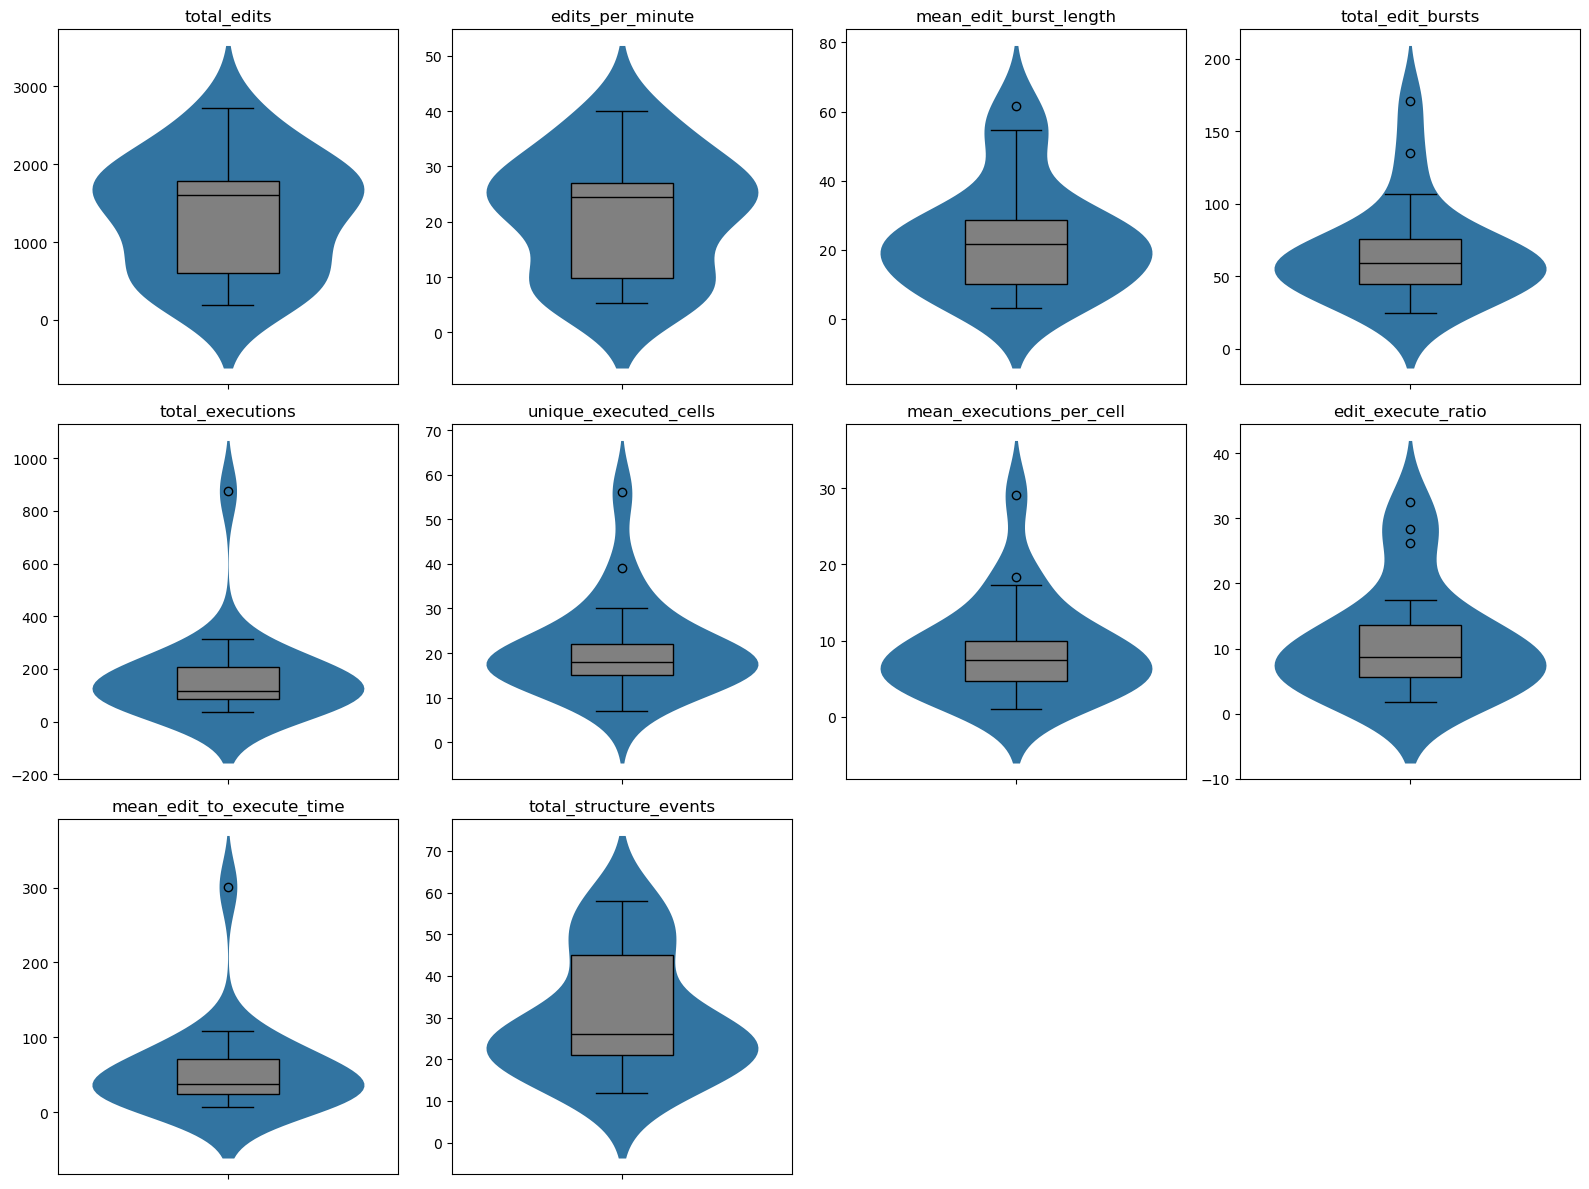

In [154]:
plot_metric_violin_distributions_on_grid(
    metrics_df,
    None
)

### Correlation

does more-edits-than-executes correlate with longer edit bursts

In [85]:
def plot_edit_execute_relationship(df: pd.DataFrame, metric1: str, metric2: str) -> None:
    """
    Plot scatter of edit–execute ratio vs. mean edit burst length.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing interaction metrics.

    Returns
    -------
    None
    """
    plt.figure(figsize=(6, 5))
    plt.scatter(
        df[metric1],
        df[metric2],
        s=60,
        alpha=0.8
    )
    plt.xlabel("Edit–Execute Ratio")
    plt.ylabel("Mean Edit Burst Length")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Pearson correlation: 0.874
P-value: 2.259e-07


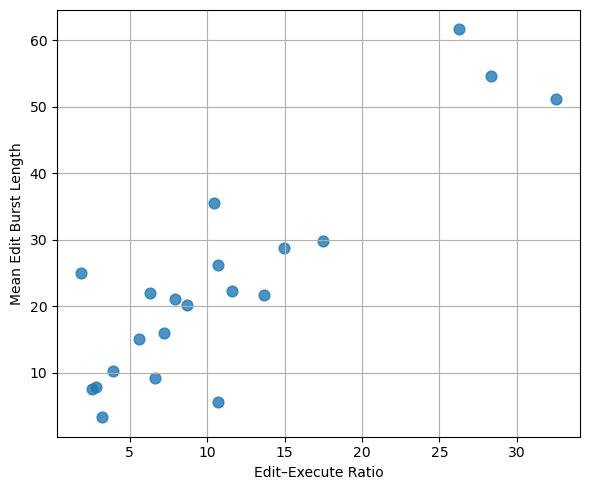

In [32]:
metric1, metric2 = "edit_execute_ratio", "mean_edit_burst_length"

correlation, p_value = stats.pearsonr(metrics_df[metric1], metrics_df[metric2])
print(f"Pearson correlation: {correlation:.3f}")
print(f"P-value: {p_value:.3e}")
plot_edit_execute_relationship(metrics_df, metric1, metric2)

### Temporal analysis

In [156]:
def build_all_window_dfs(sqlite_paths: Dict[str, str], window_size_ms: int = 300_000) -> Dict[str, pd.DataFrame]:
    """
    Generate window-level interaction metrics for all participants.

    Parameters
    ----------
    sqlite_paths : Dict[str, str]
        Mapping from participant ID to SQLite file path.
    window_size_ms : int
        Size of each time window (default is 5 minutes).

    Returns
    -------
    Dict[str, pd.DataFrame]
        participant_id -> window-level metrics DataFrame
    """
    all_window_dfs = {}

    for pid, path in sqlite_paths.items():
        signals = load_signals(path)
        actions = extract_action_events(signals)

        windows = segment_actions_by_time(actions, window_size_ms)
        window_df = compute_window_metrics(windows)

        # Defensive: ensure expected columns exist
        for col in ["edits", "executions", "outputs", "structure"]:
            if col not in window_df:
                window_df[col] = 0

        all_window_dfs[pid] = window_df

    return all_window_dfs

def normalize_window_time(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add a normalized_time column in [0,1] to a window metrics DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Window-level metrics DataFrame.

    Returns
    -------
    pd.DataFrame
        DataFrame with added normalized_time column.
    """
    df = df.copy()
    if len(df) > 1:
        df["normalized_time"] = df["window"] / (len(df) - 1)
    else:
        df["normalized_time"] = 0.0
    return df

def aggregate_normalized_temporal_patterns(all_window_dfs: Dict[str, pd.DataFrame], num_bins: int = 11) -> pd.DataFrame:
    """
    Aggregate window-level metrics across participants using normalized time.

    Parameters
    ----------
    num_bins : int
        Number of normalized time bins.

    Returns
    -------
    pd.DataFrame
        Mean interaction density per normalized time bin.
    """
    bins = np.linspace(0, 1, num_bins + 1)
    aggregated = []

    for pid, df in all_window_dfs.items():
        df = df.copy()
        df["time_bin"] = pd.cut(
            df["normalized_time"],
            bins=bins,
            include_lowest=True,
            labels=False
        )
        aggregated.append(df)

    combined = pd.concat(aggregated, ignore_index=True)

    return (
        combined
        .groupby("time_bin")[["edits", "executions", "outputs", "structure"]]
        .mean()
        .reset_index()
    )

def aggregate_temporal_patterns(all_window_dfs: Dict[str, pd.DataFrame], num_bins: int = 11) -> pd.DataFrame:
    """
    Aggregate window-level metrics across participants using window indices.

    Parameters
    ----------
    num_bins : int
        Number of window bins.

    Returns
    -------
    pd.DataFrame
        Mean interaction density per window bin.
    """
    # Find the maximum window index across all participants
    max_window = max(df["window"].max() for df in all_window_dfs.values()) if all_window_dfs else 0
    bins = np.linspace(0, max_window, num_bins + 1)
    aggregated = []

    for df in all_window_dfs.values():
        df = df.copy()
        df["time_bin"] = pd.cut(
            df["window"],
            bins=bins,
            include_lowest=True,
            labels=False
        )
        aggregated.append(df)

    combined = pd.concat(aggregated, ignore_index=True)

    return (
        combined
        .groupby("time_bin")[["edits", "executions", "outputs", "structure"]]
        .mean()
        .reset_index()
    )


def plot_temporal_interaction_patterns(df: pd.DataFrame, normalized: bool = False) -> None:
    """
    Plot aggregated interaction density over normalized time.

    Parameters
    ----------
    df : pd.DataFrame
        Aggregated interaction metrics DataFrame.
    normalized : bool
        Whether the time bins are normalized or not, used for labeling x axis ticks.
    Returns
    -------
    None
    """
    plt.figure(figsize=(8, 4))

    plt.plot(df["time_bin"], df["edits"], label="Edits")
    plt.plot(df["time_bin"], df["executions"], label="Executions")
    plt.plot(df["time_bin"], df["outputs"], label="Outputs")
    plt.plot(df["time_bin"], df["structure"], label="Structure")

    if normalized:
        x_label = "Normalized Time (0=start, 1=end)"
        x_tick_labels = np.linspace(0.0, 1.0, 11).round(2)
    else:
        x_label = "Time Bin"
        x_tick_labels = df["time_bin"]

    plt.xlabel(x_label)
    plt.xticks(ticks=df["time_bin"], labels=x_tick_labels)
    plt.ylabel("Mean Actions per Window")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [157]:
window_df = compute_window_metrics(action_windows=segment_actions_by_time(
    extract_action_events(
        load_signals(dataset_dict["001"])
    )
))
all_window_dfs = build_all_window_dfs(dataset_dict)

    time_bin       edits  executions     outputs  structure
0          0  110.416667    6.694444   93.111111   3.333333
1          1  159.950000   11.400000   19.950000   3.350000
2          2  154.900000    8.600000    8.750000   2.600000
3          3  120.684211   10.842105    6.578947   3.052632
4          4  130.947368   13.263158   15.315789   2.263158
5          5  153.500000   16.600000   73.850000   2.750000
6          6  109.263158   23.052632   74.526316   2.052632
7          7  124.526316   27.421053   15.526316   2.894737
8          8   90.400000   22.100000  114.600000   2.100000
9          9  125.000000   19.300000   35.300000   3.400000
10        10   59.520000   16.440000   51.200000   1.520000


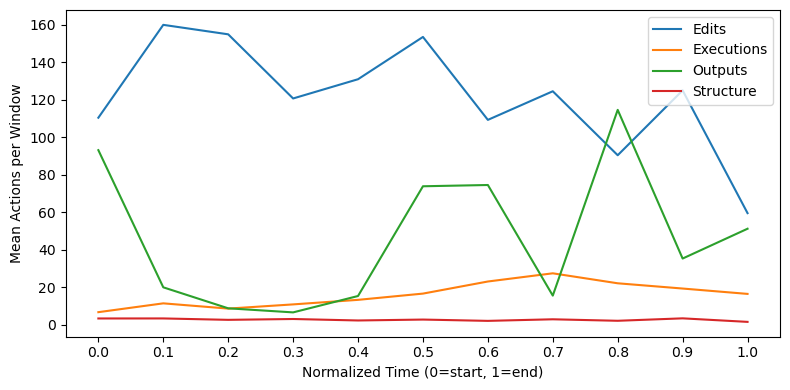

In [158]:
for pid in all_window_dfs:
    all_window_dfs[pid] = normalize_window_time(all_window_dfs[pid])
normalized_temporal_df = aggregate_normalized_temporal_patterns(all_window_dfs)
print(normalized_temporal_df)
plot_temporal_interaction_patterns(normalized_temporal_df, 
                                   normalized=True
)

Correlation between normalized time and interaction types:
Edits: r=-0.611, p=4.569e-02
Executions: r=0.757, p=6.979e-03
Outputs: r=0.198, p=5.603e-01
Structure: r=-0.530, p=9.341e-02


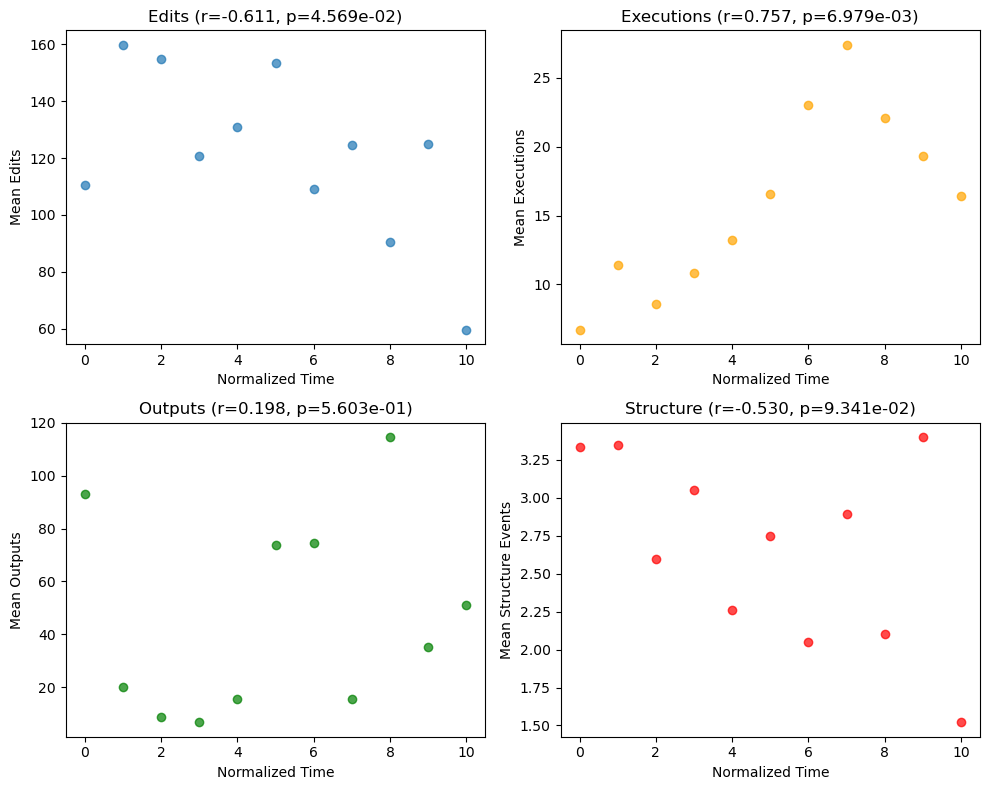

In [160]:
# Compute correlation between normalized time and interaction types
normalized_temporal_df_with_corr = normalized_temporal_df.copy()

# Calculate Pearson correlations between time_bin and each interaction type
time_bins = normalized_temporal_df["time_bin"].values

corr_edits, p_edits = stats.pearsonr(time_bins, normalized_temporal_df["edits"])
corr_executions, p_executions = stats.pearsonr(time_bins, normalized_temporal_df["executions"])
corr_outputs, p_outputs = stats.pearsonr(time_bins, normalized_temporal_df["outputs"])
corr_structure, p_structure = stats.pearsonr(time_bins, normalized_temporal_df["structure"])

print("Correlation between normalized time and interaction types:")
print(f"Edits: r={corr_edits:.3f}, p={p_edits:.3e}")
print(f"Executions: r={corr_executions:.3f}, p={p_executions:.3e}")
print(f"Outputs: r={corr_outputs:.3f}, p={p_outputs:.3e}")
print(f"Structure: r={corr_structure:.3f}, p={p_structure:.3e}")

# Visualize correlations
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].scatter(time_bins, normalized_temporal_df["edits"], alpha=0.7)
axes[0, 0].set_title(f"Edits (r={corr_edits:.3f}, p={p_edits:.3e})")
axes[0, 0].set_xlabel("Normalized Time")
axes[0, 0].set_ylabel("Mean Edits")

axes[0, 1].scatter(time_bins, normalized_temporal_df["executions"], alpha=0.7, color='orange')
axes[0, 1].set_title(f"Executions (r={corr_executions:.3f}, p={p_executions:.3e})")
axes[0, 1].set_xlabel("Normalized Time")
axes[0, 1].set_ylabel("Mean Executions")

axes[1, 0].scatter(time_bins, normalized_temporal_df["outputs"], alpha=0.7, color='green')
axes[1, 0].set_title(f"Outputs (r={corr_outputs:.3f}, p={p_outputs:.3e})")
axes[1, 0].set_xlabel("Normalized Time")
axes[1, 0].set_ylabel("Mean Outputs")

axes[1, 1].scatter(time_bins, normalized_temporal_df["structure"], alpha=0.7, color='red')
axes[1, 1].set_title(f"Structure (r={corr_structure:.3f}, p={p_structure:.3e})")
axes[1, 1].set_xlabel("Normalized Time")
axes[1, 1].set_ylabel("Mean Structure Events")

plt.tight_layout()
plt.show()

In [205]:
from sklearn.linear_model import LinearRegression


def regress_over_time_cubed(normalized_temporal_df: pd.DataFrame, metric: str, first: bool = True, second: bool = True, third: bool = True) -> None:
    """
    Perform cubic regression of executions over normalized time bins.

    Parameters
    ----------
    normalized_temporal_df : pd.DataFrame
        DataFrame with columns 'time_bin' and 'executions'.
    metric : str
        The interaction metric to regress (e.g., 'executions').

    Returns
    -------
    None
    """
    # Prepare features: time_bin, time_bin^2, time_bin^3
    X = normalized_temporal_df[["time_bin"]].values
    X_poly = []
    if first:
        X_poly.append(X)
    if second:
        X_poly.append(X**2)
    if third:
        X_poly.append(X**3)
    X_poly = np.hstack(X_poly)
    y = normalized_temporal_df[metric].values

    # Fit linear regression
    reg = LinearRegression().fit(X_poly, y)
    y_pred = reg.predict(X_poly)

    # Print coefficients
    print("Coefficients:", reg.coef_)
    print("Intercept:", reg.intercept_)
    print("R^2 score:", reg.score(X_poly, y))
    # Calculate residuals and residual sum of squares
    residuals = y - y_pred
    rss = np.sum(residuals**2)
    print("Residual Sum of Squares:", rss)
    # Calculate p-values for coefficients using t-statistics

    n = len(y)
    k = X_poly.shape[1]
    mse = rss / (n - k - 1)
    var_covar = mse * np.linalg.inv(X_poly.T @ X_poly)
    se = np.sqrt(np.diag(var_covar))
    t_stats = reg.coef_ / se
    p_values = 2 * (1 - sp_stats.t.cdf(np.abs(t_stats), n - k - 1))

    print("P-values:")
    for i, p in enumerate(p_values):
        print(f"  X^{i+1}: p={p:.4f}")

    # Test for normality of residuals using Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk Test for Normality:")
    print(f"  Test statistic: {shapiro_stat:.4f}")
    print(f"  P-value: {shapiro_p:.4f}")
    if shapiro_p > 0.05:
        print("  Result: Residuals appear normally distributed (p > 0.05)")
    else:
        print("  Result: Residuals may not be normally distributed (p <= 0.05)")

    # Test for homoskedasticity using Breusch-Pagan test

    # Calculate studentized residuals
    studentized_residuals = residuals / np.sqrt(mse)

    # Fit auxiliary regression: residuals^2 ~ X_poly
    aux_y = residuals ** 2
    aux_reg = LinearRegression().fit(X_poly, aux_y)
    aux_y_pred = aux_reg.predict(X_poly)
    aux_ss_total = np.sum((aux_y - np.mean(aux_y)) ** 2)
    aux_ss_residual = np.sum((aux_y - aux_y_pred) ** 2)
    aux_r_squared = 1 - (aux_ss_residual / aux_ss_total)

    # Calculate Breusch-Pagan test statistic
    bp_stat = n * aux_r_squared
    bp_p = 1 - f.cdf(bp_stat / k, k, n - k - 1)

    print(f"\nBreusch-Pagan Test for Homoskedasticity:")
    print(f"  Test statistic: {bp_stat:.4f}")
    print(f"  P-value: {bp_p:.4f}")
    if bp_p > 0.05:
        print("  Result: Homoskedasticity assumption holds (p > 0.05)")
    else:
        print("  Result: Heteroskedasticity detected (p <= 0.05)")

    # Plot actual vs. predicted
    plt.figure(figsize=(6, 4))
    plt.scatter(X, y, label="Actual", color="blue")
    plt.plot(X, y_pred, label="Predicted", color="red")
    plt.xlabel("Normalized Time Bin")
    plt.ylabel(metric)
    # plt.title("Regression: Executions over Time")
    plt.legend()
    plt.tight_layout()
    plt.show()

Coefficients: [ 0.88355542 -0.07882865]
Intercept: 6.727383230659969
R^2 score: 0.8679575215926083
Residual Sum of Squares: 56.175324736525816
P-values:
  X^1: p=0.0000
  X^2: p=0.0001

Shapiro-Wilk Test for Normality:
  Test statistic: 0.8804
  P-value: 0.1054
  Result: Residuals appear normally distributed (p > 0.05)

Breusch-Pagan Test for Homoskedasticity:
  Test statistic: 1.3147
  P-value: 0.5441
  Result: Homoskedasticity assumption holds (p > 0.05)


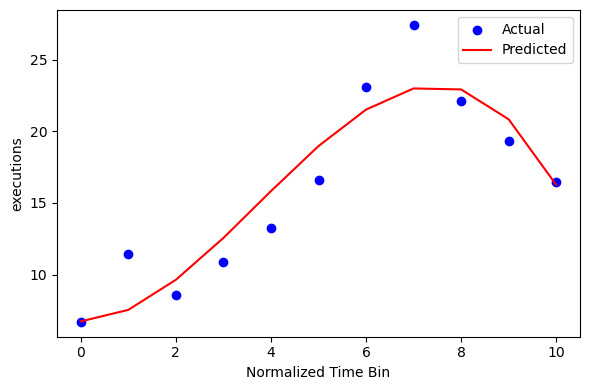

In [206]:
regress_over_time_cubed(normalized_temporal_df, "executions", False, True, True)

Coefficients: [-0.60486939]
Intercept: 142.90749404502995
R^2 score: 0.4924471540635166
Residual Sum of Squares: 4471.531514048784
P-values:
  X^1: p=0.0019

Shapiro-Wilk Test for Normality:
  Test statistic: 0.9494
  P-value: 0.6368
  Result: Residuals appear normally distributed (p > 0.05)

Breusch-Pagan Test for Homoskedasticity:
  Test statistic: 0.2427
  P-value: 0.6341
  Result: Homoskedasticity assumption holds (p > 0.05)


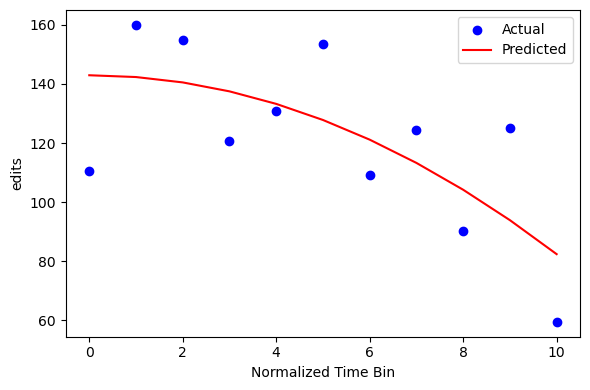

In [207]:
regress_over_time_cubed(normalized_temporal_df, "edits", False, True, False)

Coefficients: [-58.20247788  14.53995522  -0.91547595]
Intercept: 80.11606755817397
R^2 score: 0.4446279179936622
Residual Sum of Squares: 7856.295516788021
P-values for X^2, X^3:
  X^1: p=0.0121
  X^2: p=0.0257
  X^3: p=0.0406

Shapiro-Wilk Test for Normality:
  Test statistic: 0.9556
  P-value: 0.7156
  Result: Residuals appear normally distributed (p > 0.05)

Breusch-Pagan Test for Homoskedasticity:
  Test statistic: 6.3468
  P-value: 0.1866
  Result: Homoskedasticity assumption holds (p > 0.05)


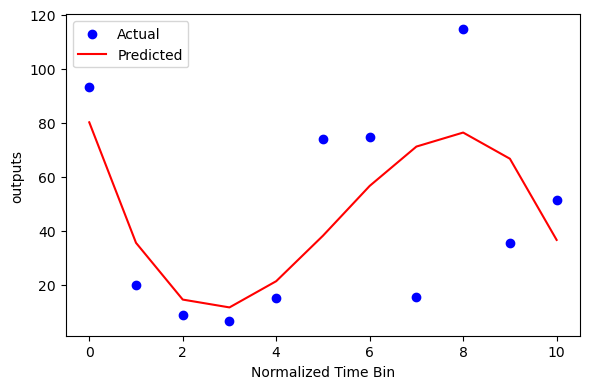

In [200]:
regress_over_time_cubed(normalized_temporal_df, "outputs", True, True, True)

Coefficients: [-0.09902711]
Intercept: 3.1602711323763955
R^2 score: 0.2811071718366902
Residual Sum of Squares: 2.7586280533870555
P-values for X^2, X^3:
  X^1: p=0.0066

Shapiro-Wilk Test for Normality:
  Test statistic: 0.9253
  P-value: 0.3655
  Result: Residuals appear normally distributed (p > 0.05)

Breusch-Pagan Test for Homoskedasticity:
  Test statistic: 3.5791
  P-value: 0.0911
  Result: Homoskedasticity assumption holds (p > 0.05)


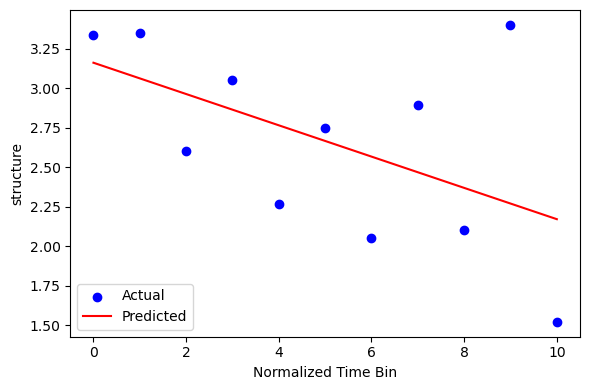

In [201]:
regress_over_time_cubed(normalized_temporal_df, "structure", True, False, False)

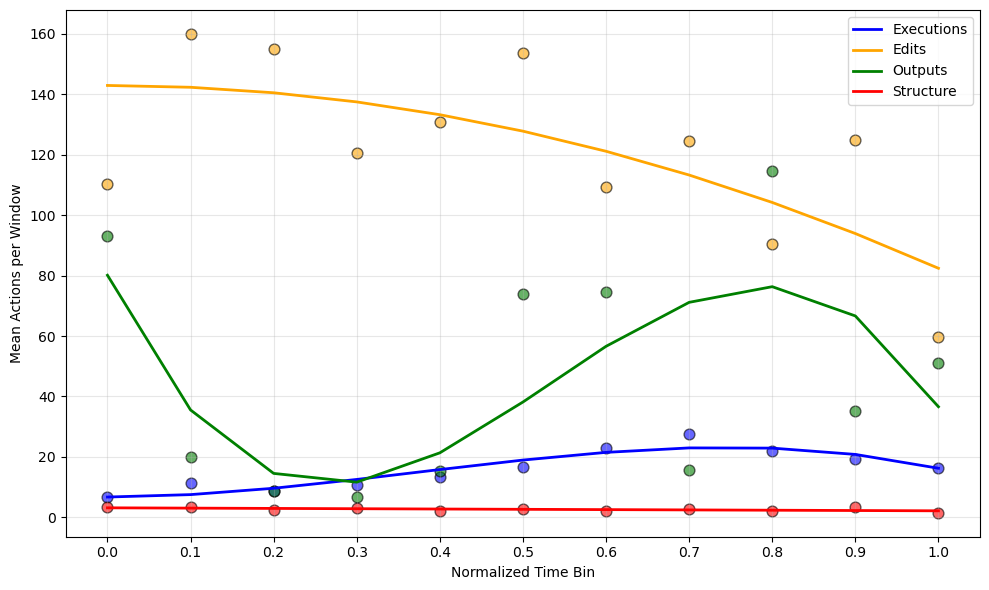

In [204]:
# Plot all regressions together with different colors and scatter of actual points
fig, ax = plt.subplots(figsize=(10, 6))

metrics_to_plot = ["executions", "edits", "outputs", "structure"]
colors = ["blue", "orange", "green", "red"]

for metric, color in zip(metrics_to_plot, colors):
    X = normalized_temporal_df[["time_bin"]].values
    y = normalized_temporal_df[metric].values

    # Determine polynomial features based on metric
    if metric == "executions":
        X_poly = np.hstack([X**2, X**3])
    elif metric == "edits":
        X_poly = X**2
    elif metric == "outputs":
        X_poly = np.hstack([X, X**2, X**3])
    elif metric == "structure":
        X_poly = X

    reg = LinearRegression().fit(X_poly, y)
    y_pred = reg.predict(X_poly)

    ax.plot(X, y_pred, label=metric.capitalize(), color=color, linewidth=2)
    ax.scatter(X, y, color=color, alpha=0.6, edgecolor='k', s=60)

ax.set_xlabel("Normalized Time Bin")
ax.set_ylabel("Mean Actions per Window")
ax.set_xticks(normalized_temporal_df["time_bin"])
ax.set_xticklabels(np.linspace(0.0, 1.0, 11).round(2))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

    time_bin       edits  executions     outputs  structure
0          0  105.571429    6.738095   83.857143   3.285714
1          1  149.857143   10.571429   19.095238   3.809524
2          2  165.571429    9.952381    8.428571   2.666667
3          3  115.285714   10.333333    6.333333   2.857143
4          4  120.650000   13.650000   17.950000   2.950000
5          5  126.076923   20.461538   71.102564   2.487179
6          6  105.473684   25.210526   15.684211   2.421053
7          7  101.555556   21.388889  122.722222   2.277778
8          8  162.687500   22.812500   41.937500   2.437500
9          9   48.666667   24.400000   79.866667   1.200000
10        10   77.400000    6.400000   13.400000   0.600000


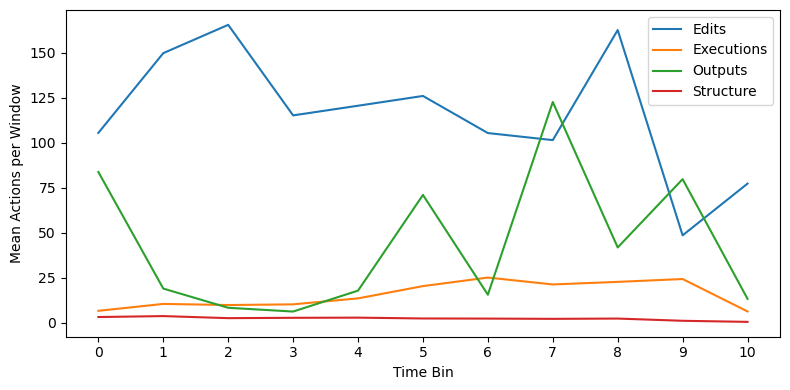

In [202]:
temporal_df = aggregate_temporal_patterns(all_window_dfs)
print(temporal_df)
plot_temporal_interaction_patterns(temporal_df)

### Clustering

See if there are different interaction styles that can be grouped, or if every developer truly has their own style.

The silhouette score can be read as:
- <0: likely misassigned clusters,
- ~0: overlapping clusters,
- \>0.5: good clustering

##### k=3

c:\Users\Niek\mambaforge\envs\mlcourse2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score: 0.12577142743947237
Representative participants: {np.int32(2): '001', np.int32(0): '002', np.int32(1): '004'}


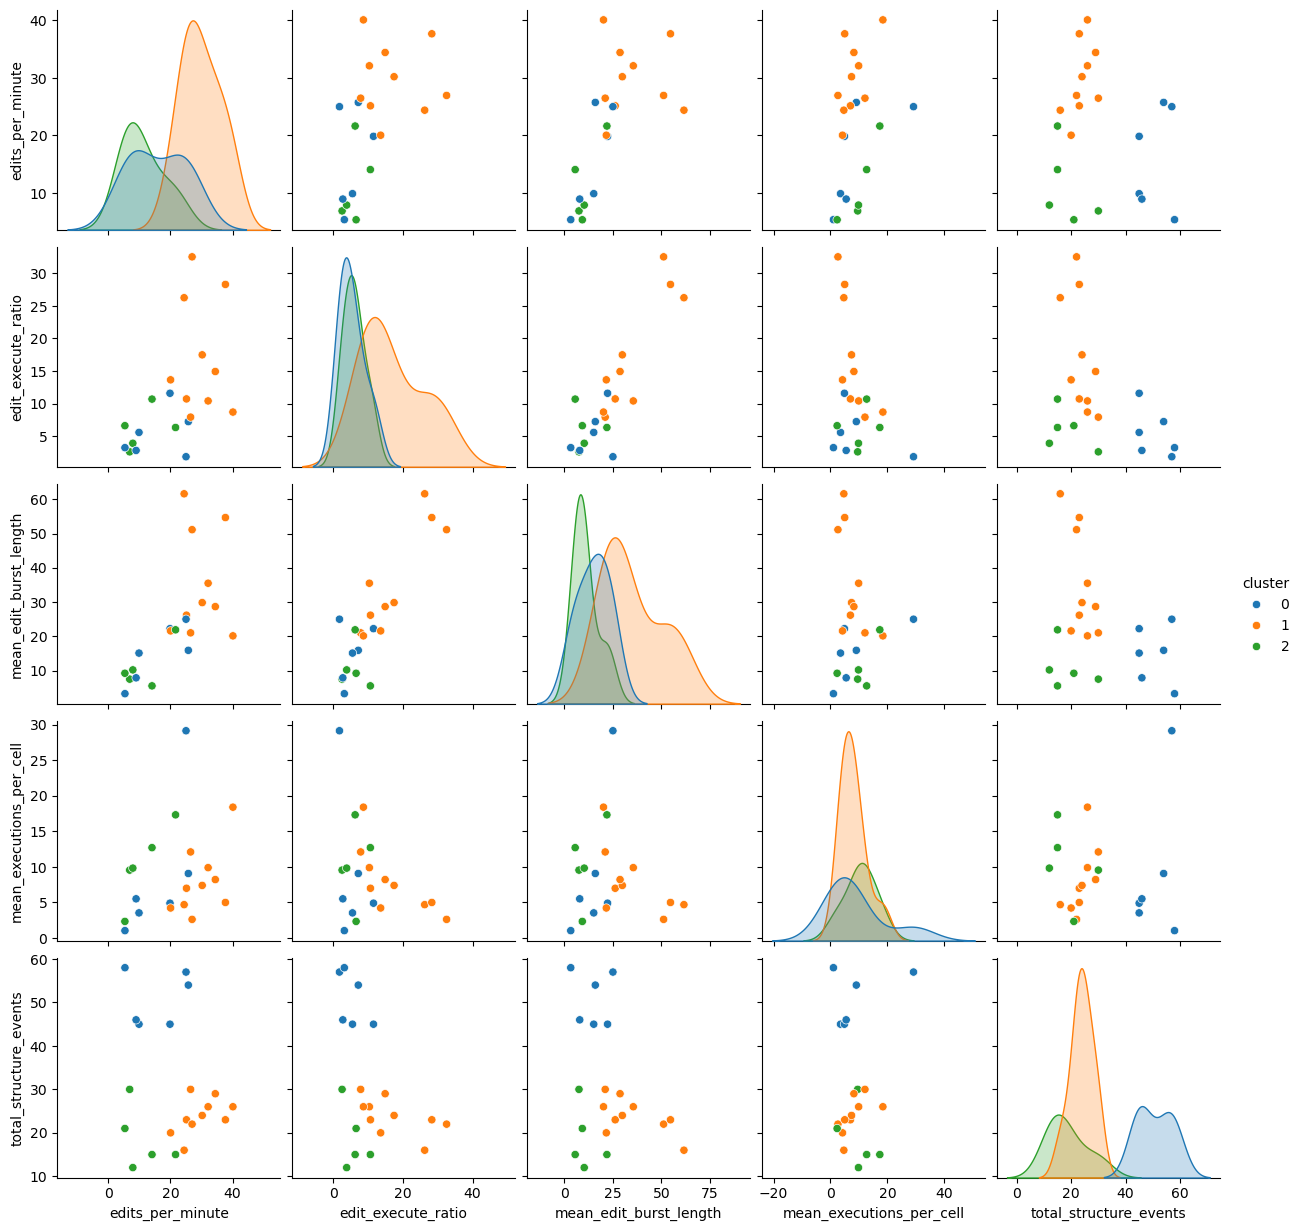

In [ ]:
cluster_features = metrics_df[
    [
        "edits_per_minute",
        "edit_execute_ratio",
        "mean_edit_burst_length",
        "mean_executions_per_cell",
        "total_structure_events",
    ]
].fillna(0)

scaler = StandardScaler()
X = scaler.fit_transform(cluster_features)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

metrics_df["cluster"] = clusters

print("Silhouette Score:", silhouette_score(metrics_df, metrics_df['cluster']))

sns.pairplot(metrics_df, vars=[
    "edits_per_minute",
    "edit_execute_ratio",
    "mean_edit_burst_length",
    "mean_executions_per_cell",
    "total_structure_events",
], hue="cluster", palette="tab10")
plt.show()

##### k=2

c:\Users\Niek\mambaforge\envs\mlcourse2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score: 0.3633224049766596
Representative participants: {np.int32(0): '001', np.int32(1): '009'}


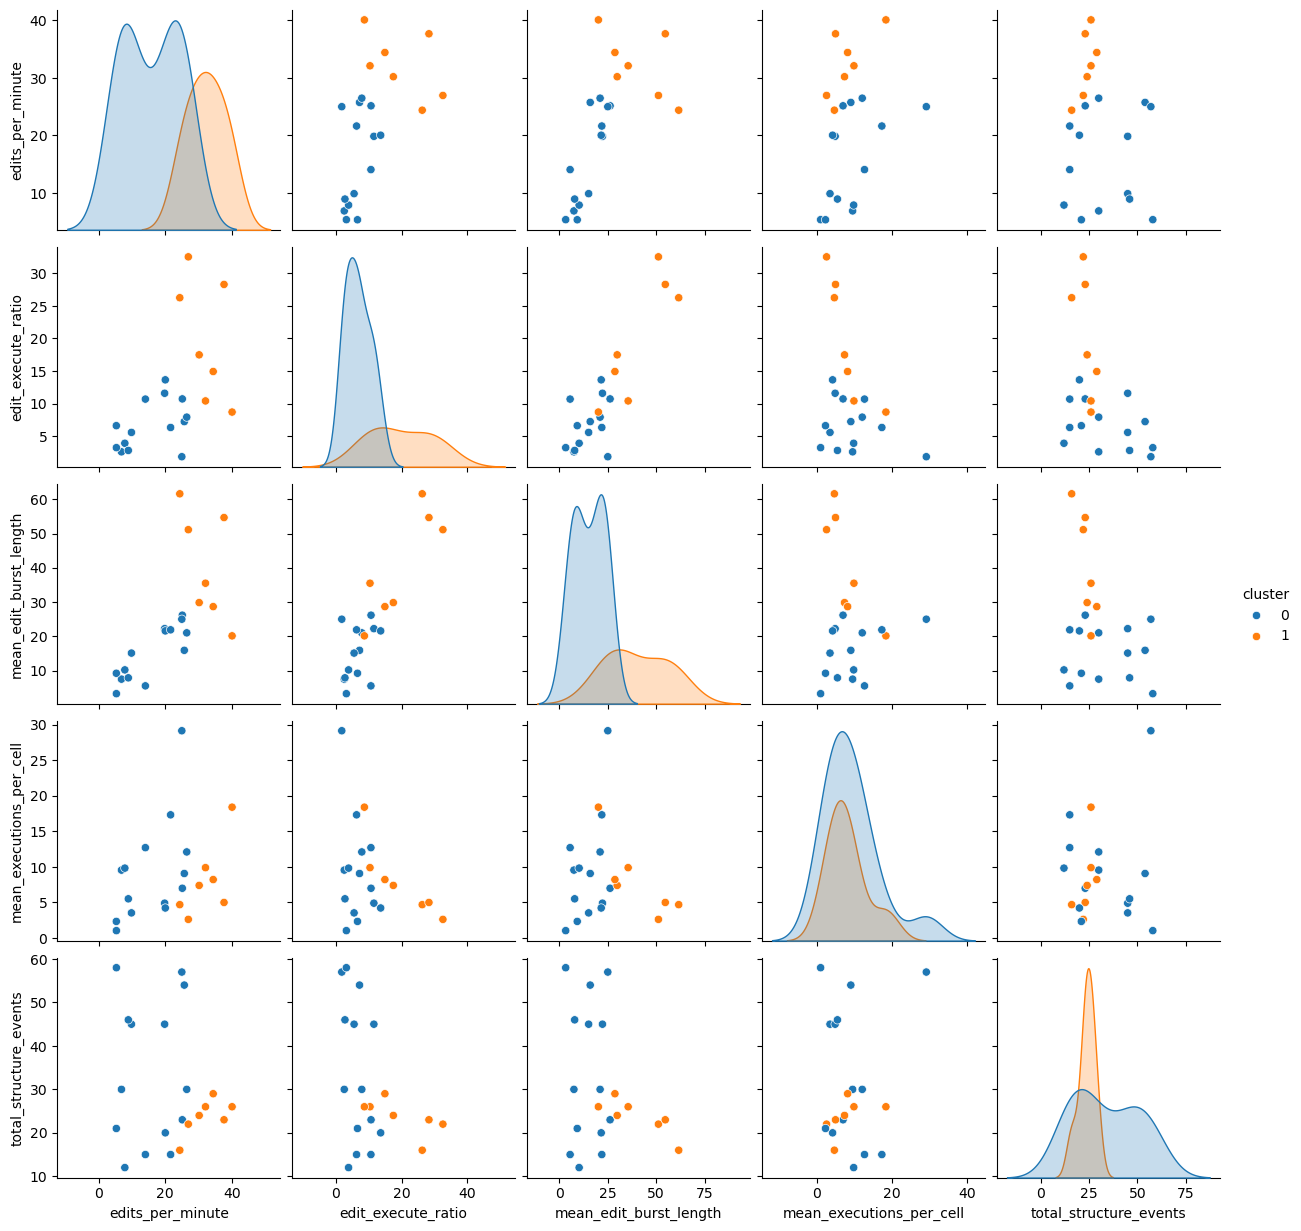

In [ ]:
cluster_features = metrics_df[
    [
        "edits_per_minute",
        "edit_execute_ratio",
        "mean_edit_burst_length",
        "mean_executions_per_cell",
        "total_structure_events",
    ]
].fillna(0)

scaler = StandardScaler()
X = scaler.fit_transform(cluster_features)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)

metrics_df["cluster"] = clusters

print("Silhouette Score:", silhouette_score(metrics_df, metrics_df['cluster']))

sns.pairplot(metrics_df, vars=[
    "edits_per_minute",
    "edit_execute_ratio",
    "mean_edit_burst_length",
    "mean_executions_per_cell",
    "total_structure_events",
], hue="cluster", palette="tab10")
plt.show()



##### k=4

c:\Users\Niek\mambaforge\envs\mlcourse2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score: -0.15561151007595925
Representative participants: {np.int32(2): '001', np.int32(0): '002', np.int32(1): '004', np.int32(3): '009'}


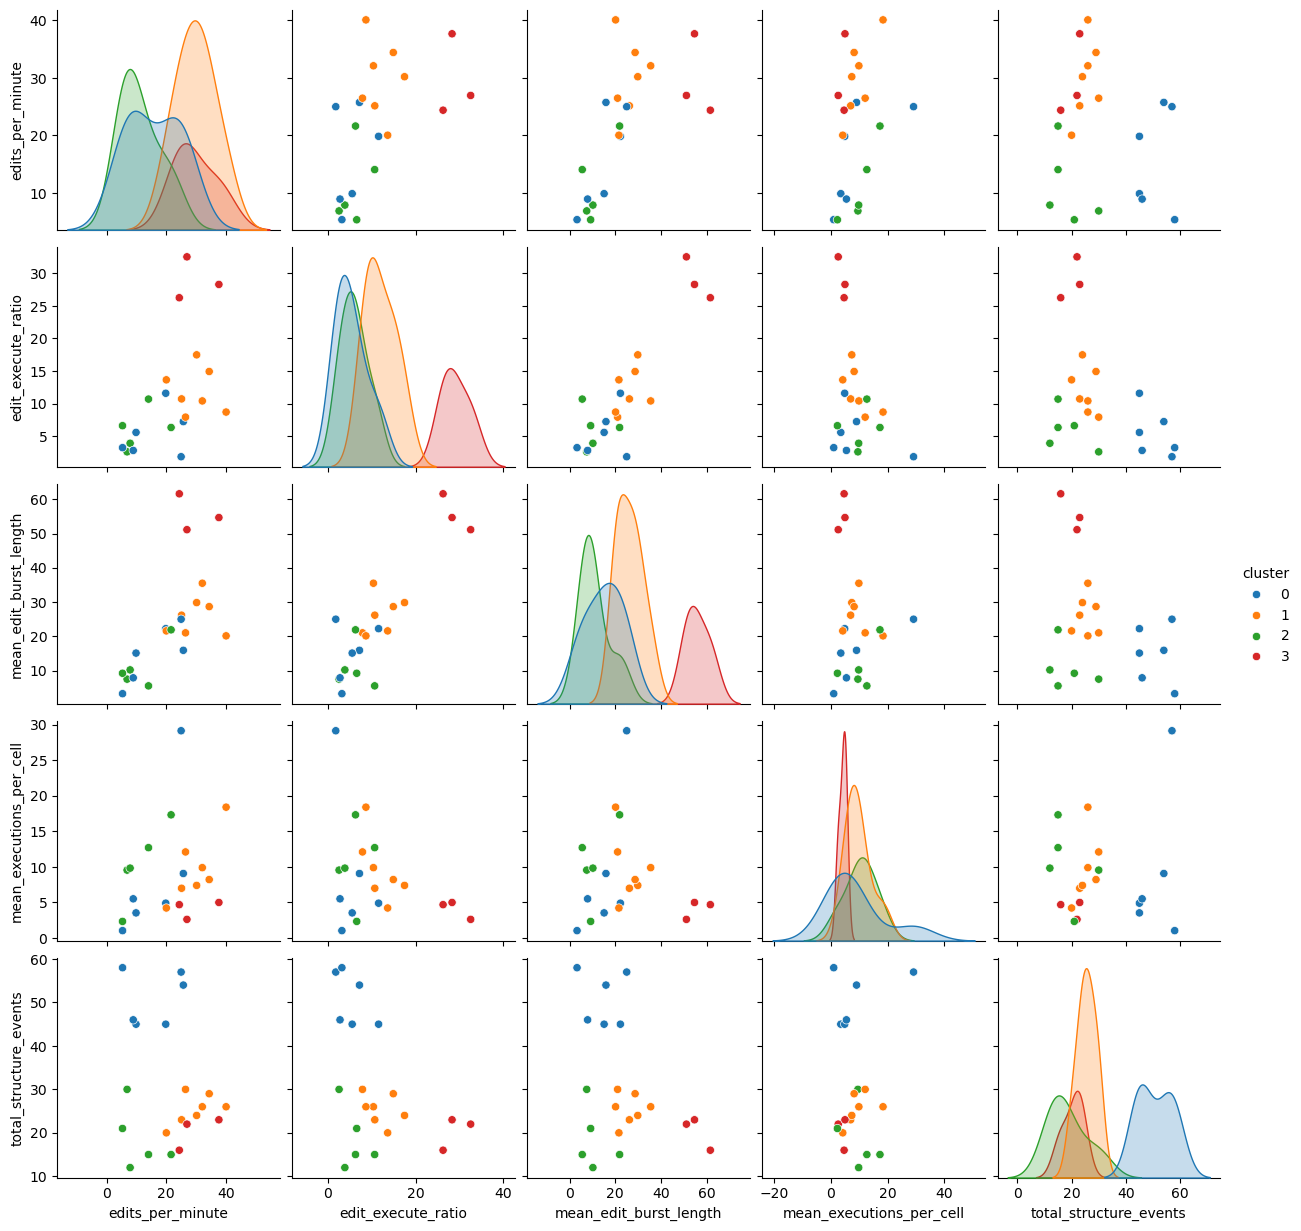

In [ ]:
cluster_features = metrics_df[
    [
        "edits_per_minute",
        "edit_execute_ratio",
        "mean_edit_burst_length",
        "mean_executions_per_cell",
        "total_structure_events",
    ]
].fillna(0)

scaler = StandardScaler()
X = scaler.fit_transform(cluster_features)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)

metrics_df["cluster"] = clusters

print("Silhouette Score:", silhouette_score(metrics_df, metrics_df['cluster']))

sns.pairplot(metrics_df, vars=[
    "edits_per_minute",
    "edit_execute_ratio",
    "mean_edit_burst_length",
    "mean_executions_per_cell",
    "total_structure_events",
], hue="cluster", palette="tab10")
plt.show()

